# **Conexión**

In [ ]:
%pip install seaborn matplotlib scipy jinja2

import yaml
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar configuración
with open('config.yml', 'r') as f:
    config = yaml.safe_load(f)
    config_bodega = config['bodega']

# Conexión a la base de datos OLAP
url_bodega = (
    f"{config_bodega['driver']}://{config_bodega['user']}:{config_bodega['password']}@"
    f"{config_bodega['host']}:{config_bodega['port']}/{config_bodega['db']}"
)
engine_bodega = create_engine(url_bodega)

Note: you may need to restart the kernel to use updated packages.


## **Pregunta 1:** En qué meses del año los clientes solicitan más servicios de mensajería

Esta consulta busca analizar la estacionalidad de los servicios de mensajería.

Agrupamos por **año y mes** para ver cómo varía la cantidad de servicios en el tiempo. Se utiliza la dimensión de fecha `dim_fecha` para obtener el año y el mes a partir de la fecha de inicio de cada servicio.

---



RESUMEN: 

El mes con mayor demanda fue Mayo con 4,725 servicios (16.62%).
El mes con menor demanda fue Octubre con 12 servicios (0.04%).



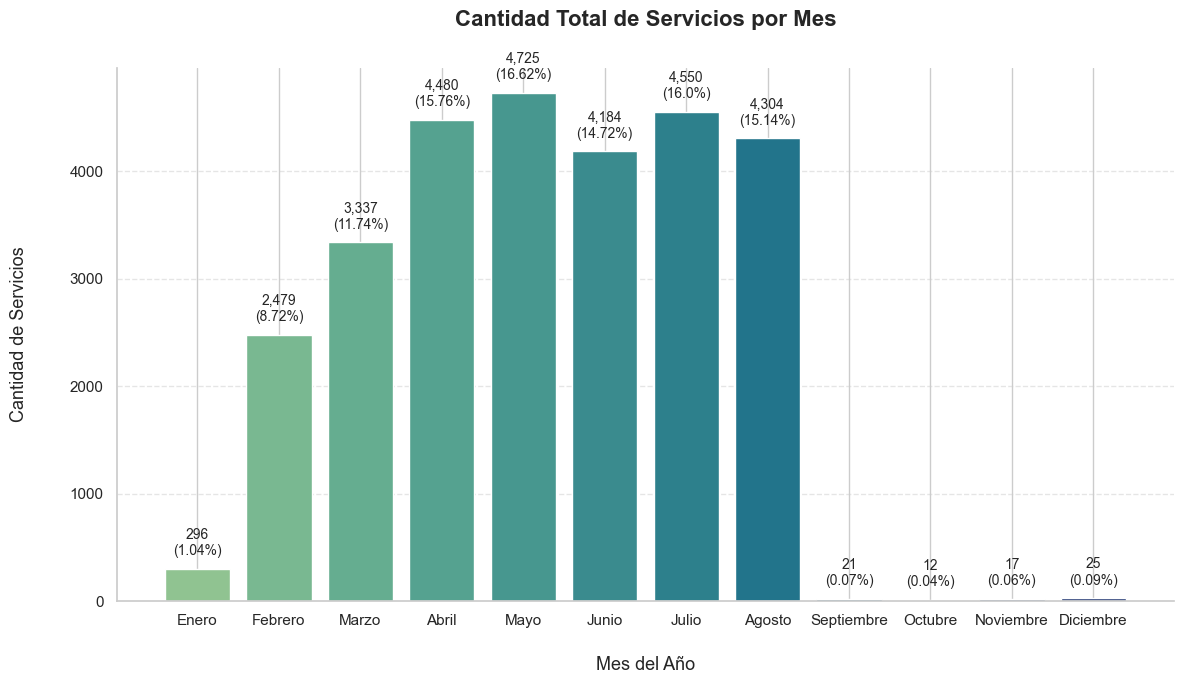

In [61]:
# Consulta SQL
query = """
SELECT f.mes, COUNT(*) AS cantidad_servicios
FROM hecho_servicio hs
JOIN dim_fecha f ON hs.id_fecha_inicio = f.id_fecha
GROUP BY f.mes
ORDER BY f.mes;
"""
df = pd.read_sql(query, con=engine_bodega)

# Asignar nombre del mes
nombres_meses = [
    "Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio",
    "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"
]
df["nombre_mes"] = df["mes"].astype(int).apply(lambda x: nombres_meses[x - 1])

# Calcular porcentaje de participación mensual
df["porcentaje"] = (df["cantidad_servicios"] / df["cantidad_servicios"].sum() * 100).round(2)

# Ordenar por mes (por si acaso)
df = df.sort_values("mes")

# Visualización de los datos
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# Paleta de colores
colors = sns.color_palette("crest", len(df))
bars = plt.bar(df["nombre_mes"], df["cantidad_servicios"], color=colors)

# Etiquetas en las barras
for bar, pct in zip(bars, df["porcentaje"]):
    height = bar.get_height()
    label = f'{int(height):,}\n({pct}%)'
    plt.text(bar.get_x() + bar.get_width() / 2, height + 100, label,
             ha='center', va='bottom', fontsize=10)

# Títulos y estética
plt.title("Cantidad Total de Servicios por Mes", fontsize=16, fontweight='bold', pad=30)
plt.xlabel("Mes del Año", fontsize=13, labelpad=20)
plt.ylabel("Cantidad de Servicios", fontsize=13, labelpad=30)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()

# Mostrar resumen
mes_max = df.loc[df["cantidad_servicios"].idxmax()]
mes_min = df.loc[df["cantidad_servicios"].idxmin()]

print("\nRESUMEN: \n")
print(f"El mes con mayor demanda fue {mes_max['nombre_mes']} con {mes_max['cantidad_servicios']:,} servicios ({mes_max['porcentaje']}%).")
print(f"El mes con menor demanda fue {mes_min['nombre_mes']} con {mes_min['cantidad_servicios']:,} servicios ({mes_min['porcentaje']}%).\n")


## **Pregunta 2:** Cuáles son los días donde más solicitudes hay

A partir de la relación entre `hecho_servicio` y `dim_fecha`, se agruparon los datos por fecha completa (f.date) para identificar los días específicos con mayor volumen de servicios.

---

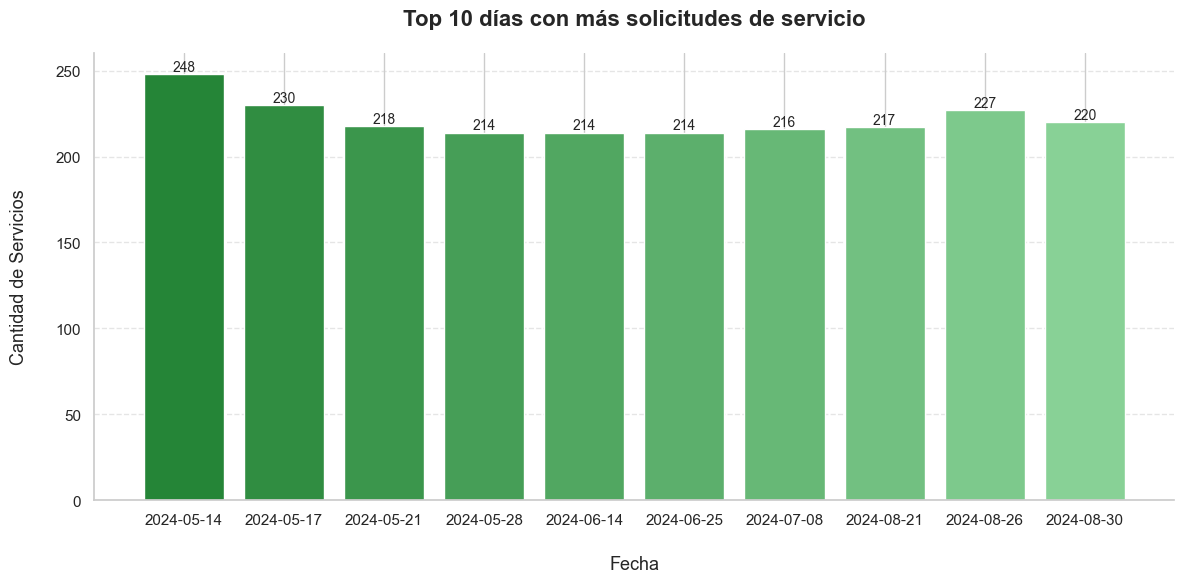

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Consulta SQL
query = """
SELECT f.date AS fecha, COUNT(*) AS cantidad_servicios
FROM hecho_servicio hs
JOIN dim_fecha f ON hs.id_fecha_inicio = f.id_fecha
GROUP BY f.date
ORDER BY cantidad_servicios DESC
LIMIT 10;
"""
df = pd.read_sql(query, con=engine_bodega)

# Ordenar por fecha
df = df.sort_values("fecha")

# Visualización
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# Paleta de colores personalizada
colors = sns.color_palette("blend:#258537,#88d196", len(df))
bars = plt.bar(df["fecha"].astype(str), df["cantidad_servicios"], color=colors)

for bar in bars:
    yval = bar.get_height()
    label = f"{int(yval):,}"
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, label, ha='center', va='bottom', fontsize=10)

plt.title("Top 10 días con más solicitudes de servicio", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Fecha", fontsize=13, labelpad=20)
plt.ylabel("Cantidad de Servicios", fontsize=13, labelpad=20)
plt.xticks(rotation=0, ha="center", fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()

## **Pregunta 3:** A qué hora los mensajeros están más ocupados.

Utilizando directamente la tabla de hechos, se agruparon los servicios por la columna `hora_inicio`, lo que permitió determinar las horas del día con mayor carga operativa

---

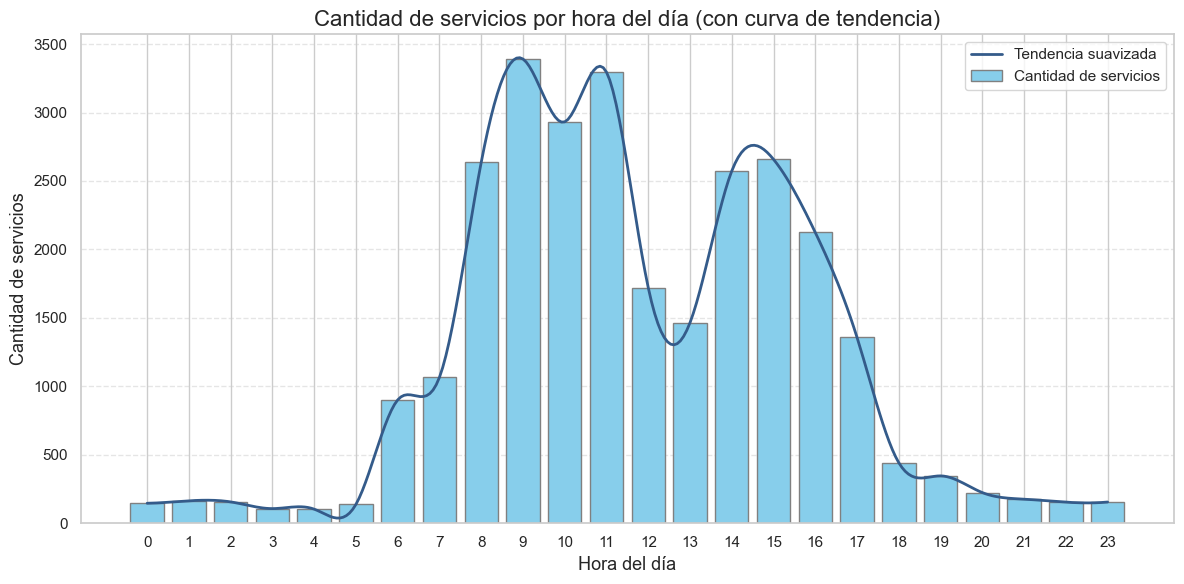

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import numpy as np

# Consulta SQL
query = """
SELECT 
    hora_inicio AS hora,
    COUNT(*) AS cantidad_servicios
FROM hecho_servicio
GROUP BY hora_inicio
ORDER BY hora_inicio;
"""

df = pd.read_sql(query, con=engine_bodega)

# Convertir hora a entero
df["hora_entera"] = df["hora"].apply(lambda x: x.hour)
agg = df.groupby("hora_entera")["cantidad_servicios"].sum().reset_index()

# Interpolación para curva 
x = agg["hora_entera"]
y = agg["cantidad_servicios"]
x_smooth = np.linspace(x.min(), x.max(), 300)  
spl = make_interp_spline(x, y, k=3)           
y_smooth = spl(x_smooth)

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(x, y, color="skyblue", edgecolor="gray", label="Cantidad de servicios")
plt.plot(x_smooth, y_smooth, color="#345b8a", linewidth=2, label="Tendencia suavizada")

plt.title("Cantidad de servicios por hora del día (con curva de tendencia)", fontsize=16)
plt.xlabel("Hora del día", fontsize=13)
plt.ylabel("Cantidad de servicios", fontsize=13)
plt.xticks(range(0, 24))
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


## **Pregunta 4:** Número de servicios solicitados por cliente y por mes

En esta consulta se combinó la información de `hecho_servicio` con `dim_fecha`, agrupando por **cliente**, **año** y **mes**. Esta consulta revela qué clientes son más activos y cómo varía su comportamiento de uso en el tiempo.

---

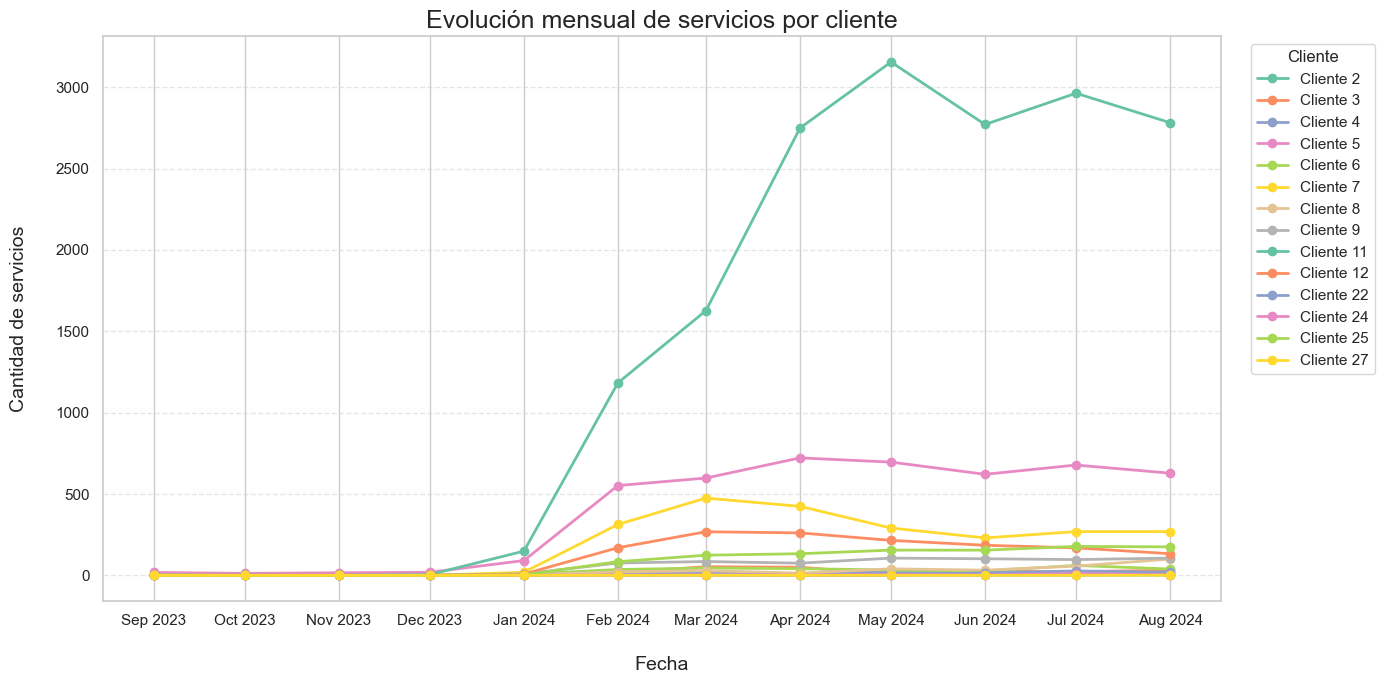

cliente_id,2,3,4,5,6,7,8,9,11,12,22,24,25,27
anio_mes,,,,,,,,,,,,,,
2023-09-01 00:00:00,0,0,0,18,3,0,0,0,0,0,0,0,0,0
2023-10-01 00:00:00,0,0,0,12,0,0,0,0,0,0,0,0,0,0
2023-11-01 00:00:00,0,0,1,16,0,0,0,0,0,0,0,0,0,0
2023-12-01 00:00:00,0,0,1,19,0,0,0,0,5,0,0,0,0,0
2024-01-01 00:00:00,1,0,4,91,7,19,3,9,149,8,0,1,4,0
2024-02-01 00:00:00,16,17,10,552,36,313,21,76,1183,170,0,1,84,0
2024-03-01 00:00:00,5,53,24,598,45,475,29,85,1627,268,0,4,124,0
2024-04-01 00:00:00,2,50,8,722,41,424,14,75,2749,261,0,1,133,0
2024-05-01 00:00:00,2,7,20,696,33,291,40,106,3155,215,0,5,155,0


In [ ]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_theme(style="whitegrid")

# Consulta SQL
query = """
SELECT hs.cliente_id, f.anio, f.mes, COUNT(*) AS cantidad_servicios
FROM hecho_servicio hs
JOIN dim_fecha f ON hs.id_fecha_inicio = f.id_fecha
GROUP BY hs.cliente_id, f.anio, f.mes
ORDER BY f.anio, f.mes;
"""
df = pd.read_sql(query, con=engine_bodega)

# Convertir año-mes a datetime
df["anio_mes"] = pd.to_datetime(df["anio"].astype(str) + "-" + df["mes"].astype(str).str.zfill(2))

df_pivot = df.pivot_table(index="anio_mes", columns="cliente_id", values="cantidad_servicios", fill_value=0)

# Paleta de colores
palette = sns.color_palette("Set2", n_colors=len(df_pivot.columns))

# Graficar
plt.figure(figsize=(14, 7))
for i, cliente in enumerate(df_pivot.columns):
    plt.plot(
        df_pivot.index, 
        df_pivot[cliente], 
        label=f"Cliente {cliente}", 
        color=palette[i], 
        marker="o",    
        linewidth=2    
    )

plt.title("Evolución mensual de servicios por cliente", fontsize=18)
plt.xlabel("Fecha", fontsize=14, labelpad=20)
plt.ylabel("Cantidad de servicios", fontsize=14, labelpad=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=0)  # 
plt.legend(title="Cliente", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Tabla pivotada con totales
df_pivot.loc['Total'] = df_pivot.sum()

df_pivot.style\
    .set_table_attributes('style="font-size: 15px"')\
    .set_caption("Servicios por Cliente - Tabla Pivotada con Totales")\
    .format("{:.0f}")
    

## **Pregunta 5:** Mensajeros más eficientes (Los que más servicios prestan)  

Desde la tabla de hechos, se contó el número de servicios realizados por cada `mensajero_id`. Así se identifican los mensajeros con mayor productividad.

---

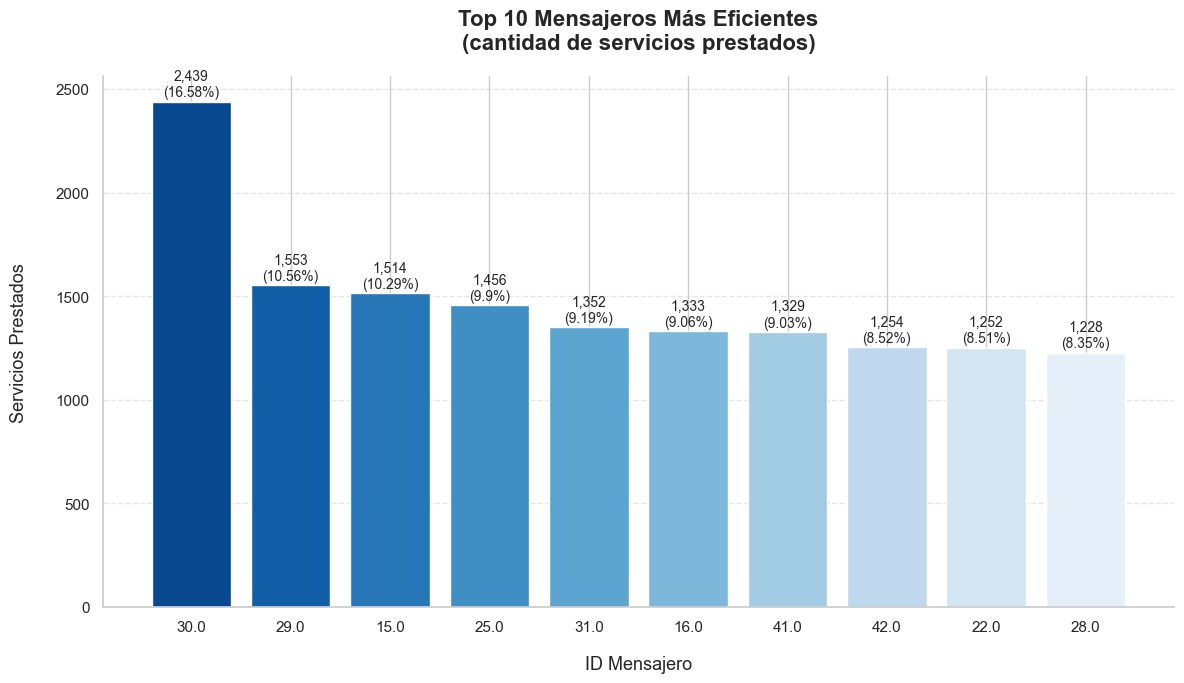


RESUMEN:
El mensajero con más servicios es el ID 30.0 con 2,439 servicios (16.58%).
En conjunto, estos 10 mensajeros realizaron un total de 14,710 servicios.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Consulta SQL
query = """
SELECT mensajero_id, COUNT(*) AS servicios_prestados
FROM hecho_servicio
GROUP BY mensajero_id
ORDER BY servicios_prestados DESC
LIMIT 10;
"""
df = pd.read_sql(query, con=engine_bodega)

# Calcular porcentaje sobre el total del top 10
df["porcentaje"] = (df["servicios_prestados"] / df["servicios_prestados"].sum() * 100).round(2)

# Convertir ID a string para visualización
df["mensajero_id"] = df["mensajero_id"].astype(str)

# Visualización
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# Paleta de colores
colors = sns.color_palette("Blues_r", len(df))
bars = plt.bar(df["mensajero_id"], df["servicios_prestados"], color=colors)

for bar, pct in zip(bars, df["porcentaje"]):
    height = bar.get_height()
    label = f'{int(height):,}\n({pct}%)'
    plt.text(bar.get_x() + bar.get_width() / 2, height + 10, label,
             ha='center', va='bottom', fontsize=10)

plt.title("Top 10 Mensajeros Más Eficientes\n(cantidad de servicios prestados)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("ID Mensajero", fontsize=13, labelpad=15)
plt.ylabel("Servicios Prestados", fontsize=13, labelpad=20)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()

# Mostrar resumen
top1 = df.iloc[0]
print("\nRESUMEN:")
print(f"El mensajero con más servicios es el ID {top1['mensajero_id']} con {top1['servicios_prestados']:,} servicios ({top1['porcentaje']}%).")
print(f"En conjunto, estos 10 mensajeros realizaron un total de {df['servicios_prestados'].sum():,} servicios.\n")


## **Pregunta 6:** Cuáles son las sedes que más servicios solicitan por cada cliente.

Esta consulta usa la tabla `hecho_servicio`, agrupando por **cliente_id** y **sede_id**, lo que permite conocer qué sedes dentro de cada cliente generan mayor demanda.

---

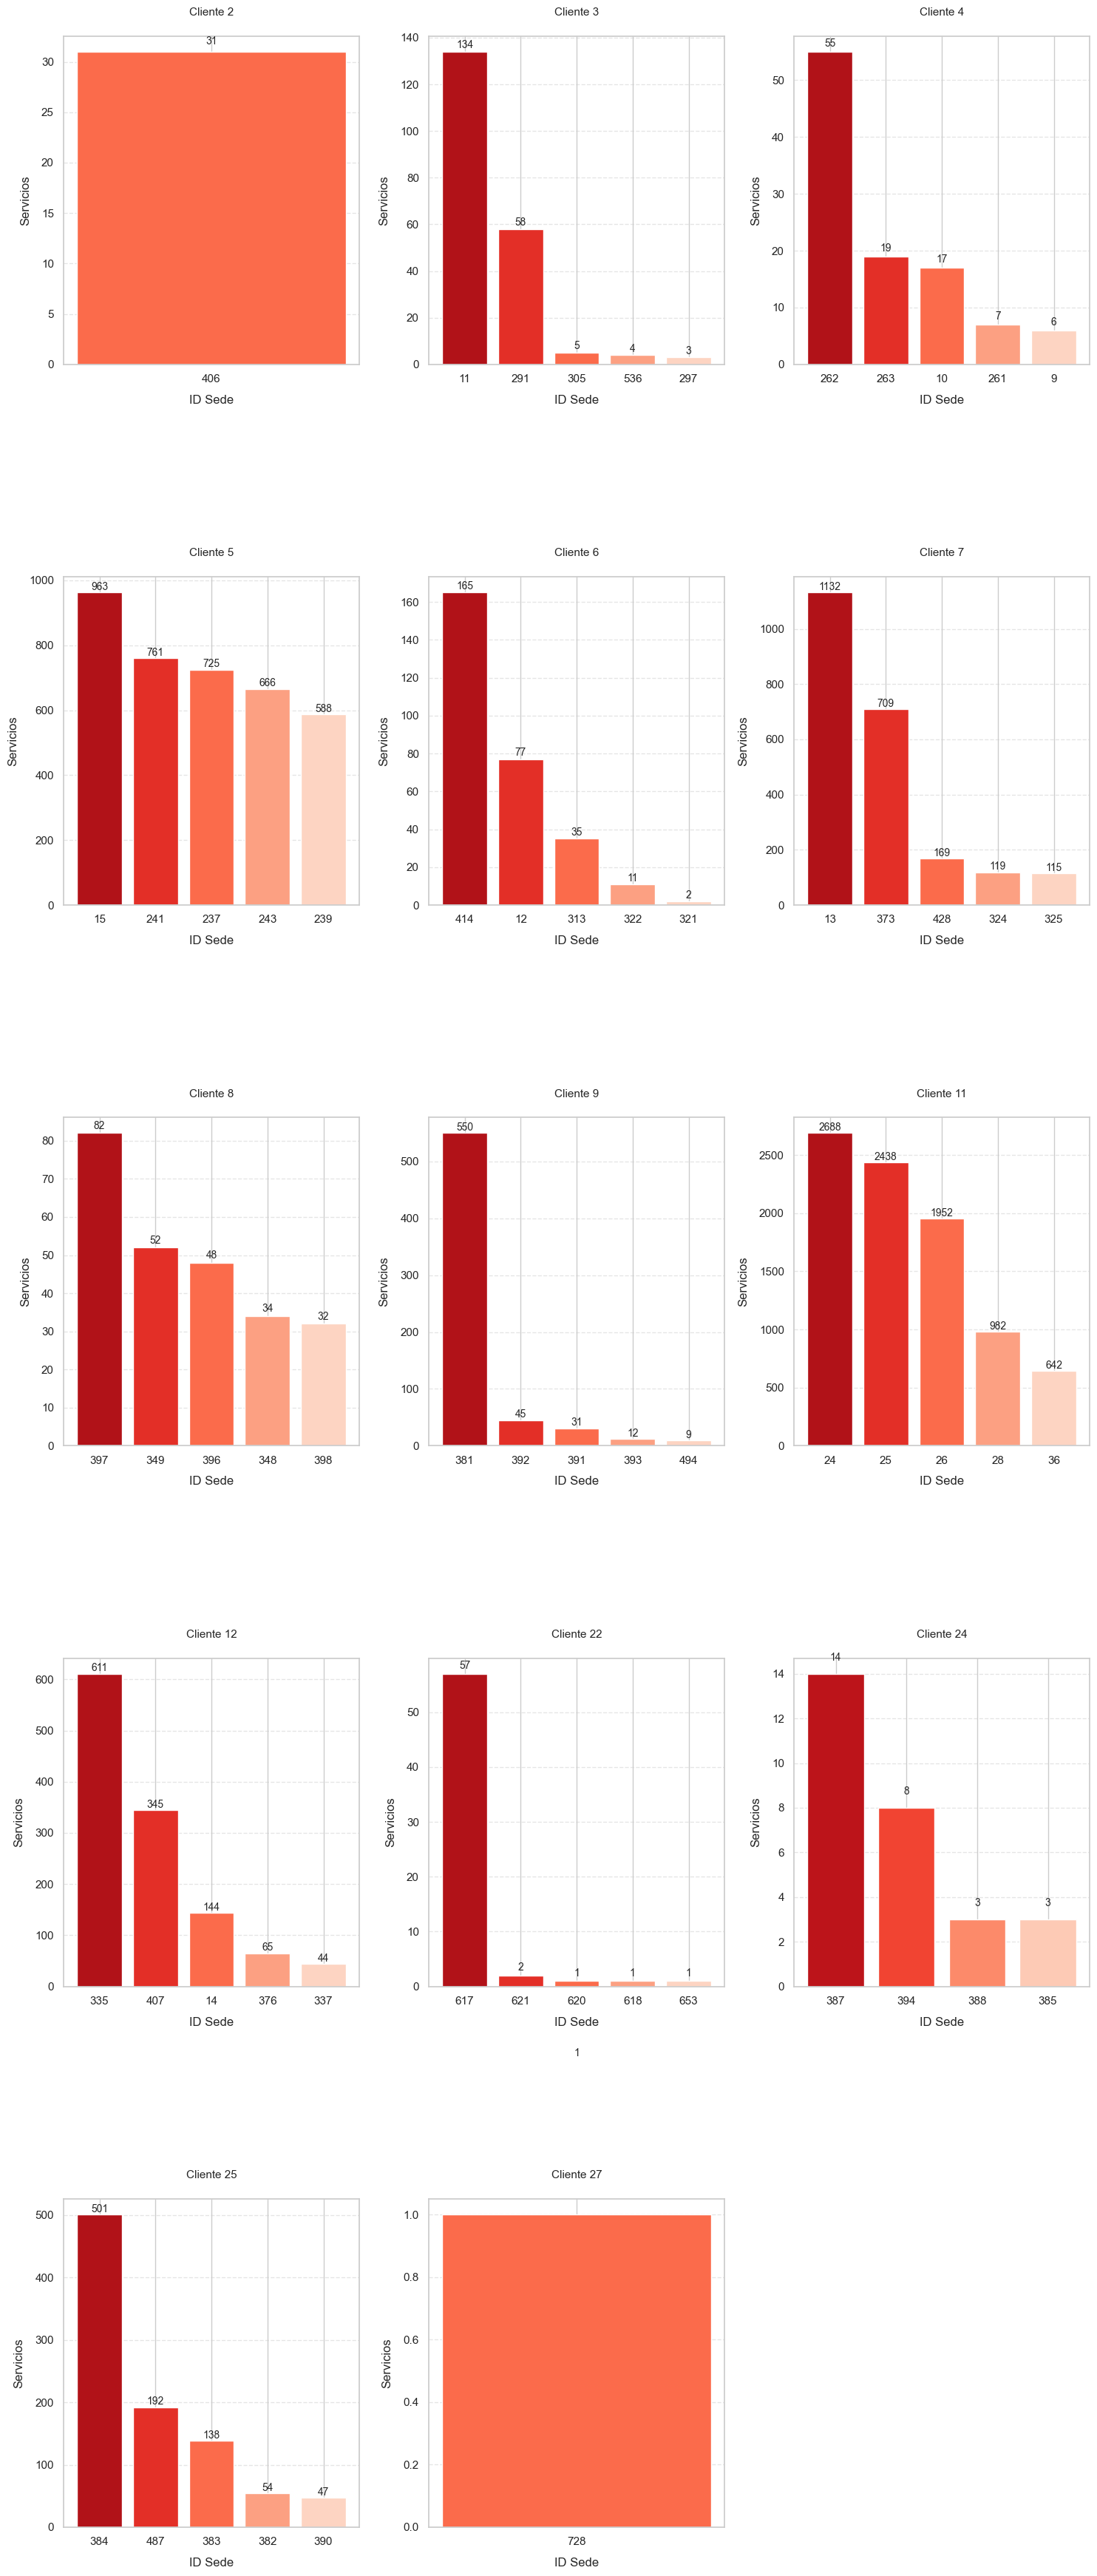

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

sns.set_theme(style="whitegrid")

# Consulta SQL
query = """
SELECT cliente_id, sede_id, COUNT(*) AS cantidad_servicios
FROM hecho_servicio
GROUP BY cliente_id, sede_id
ORDER BY cliente_id, cantidad_servicios DESC;
"""
df = pd.read_sql(query, con=engine_bodega)

# Asegurarse que los conteos sean enteros
df['cantidad_servicios'] = df['cantidad_servicios'].astype(int)

# Obtenemos los clientes únicos y top_n sedes
clientes = df['cliente_id'].unique()
top_n = 5

# Parámetros de grid
n_cols = 3 
n_rows = math.ceil(len(clientes) / n_cols)

# Crear figura y ejes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 7))
axes = axes.flatten()  

# Generar subplots
for idx, cliente in enumerate(clientes):
    ax = axes[idx]
    df_cliente = df[df['cliente_id'] == cliente].nlargest(top_n, 'cantidad_servicios')
    colors = sns.color_palette("Reds_r", len(df_cliente))
    
    bars = ax.bar(df_cliente['sede_id'].astype(str), df_cliente['cantidad_servicios'], color=colors)
    ax.set_title(f"Cliente {cliente}", fontsize=11, pad=20)
    ax.set_xlabel("ID Sede", labelpad=10)
    ax.set_ylabel("Servicios", labelpad=10)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f"{int(yval)}",
                ha='center', va='bottom', fontsize=10)

# Eliminar ejes sobrantes si hay más subplots que clientes
for i in range(len(clientes), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Crear tabla pivotada
df_pivot = df.pivot_table(index='cliente_id', columns='sede_id', values='cantidad_servicios', fill_value=0, aggfunc='sum')

# Agregar fila "Total" por sede
df_pivot.loc['Total'] = df_pivot.sum()

# Agregar columna "Total" por cliente
df_pivot['Total'] = df_pivot.sum(axis=1)

# Mostrar tabla
styled_table = df_pivot.style\
    .set_caption("Resumen de Servicios por Cliente y Sede")\
    .format("{:,.0f}")\
    .set_table_attributes('style="font-size: 12px"')
    
display(styled_table)


## **Pregunta 7:** Cuál es el tiempo promedio de entrega desde que se solicita el servicio hasta que se cierra el caso.

Aquí se calcula el promedio del campo `tiempo_total_servicio` dentro de la tabla de hechos, lo que refleja cuánto tarda en promedio un servicio desde que se inicia hasta que se cierra. Este indicador ayuda a evaluar la eficiencia del proceso completo.

---

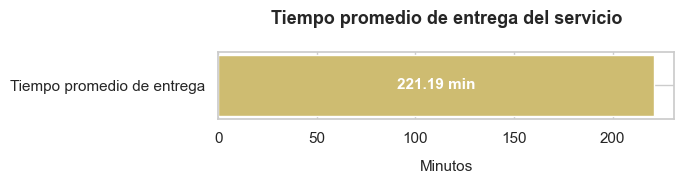

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

# Consulta 
query = """
SELECT ROUND(AVG(tiempo_total_servicio)::numeric, 2) AS promedio_minutos
FROM hecho_servicio;
"""
df = pd.read_sql(query, con=engine_bodega)

# Extraer valor
promedio = df['promedio_minutos'][0]

# Graficar
plt.figure(figsize=(7, 2))
plt.barh(['Tiempo promedio de entrega'], [promedio], color="#CEBC71")
plt.xlabel("Minutos", fontsize=11, labelpad=10)
plt.title("Tiempo promedio de entrega del servicio", fontsize=13, fontweight='bold', pad=20)
plt.xlim(0, promedio + 10)
plt.text(promedio / 2, 0, f"{promedio} min", va='center', ha='center', fontsize=11, color='white', fontweight='bold')
plt.tight_layout()
plt.show()


## **Pregunta 8:** Mostrar los tiempos de espera por cada fase del servicio: Iniciado, Con mensajero asignado, recogido en origen, Entregado en Destino, Cerrado. En que fase del servicio hay más demoras?

En esta consulta se calcularon los promedios de duración de cada fase del servicio (iniciado, asignado, recogido, entregado) utilizando campos específicos de la tabla de hechos. Así se puede detectar en qué etapa hay más demoras

---

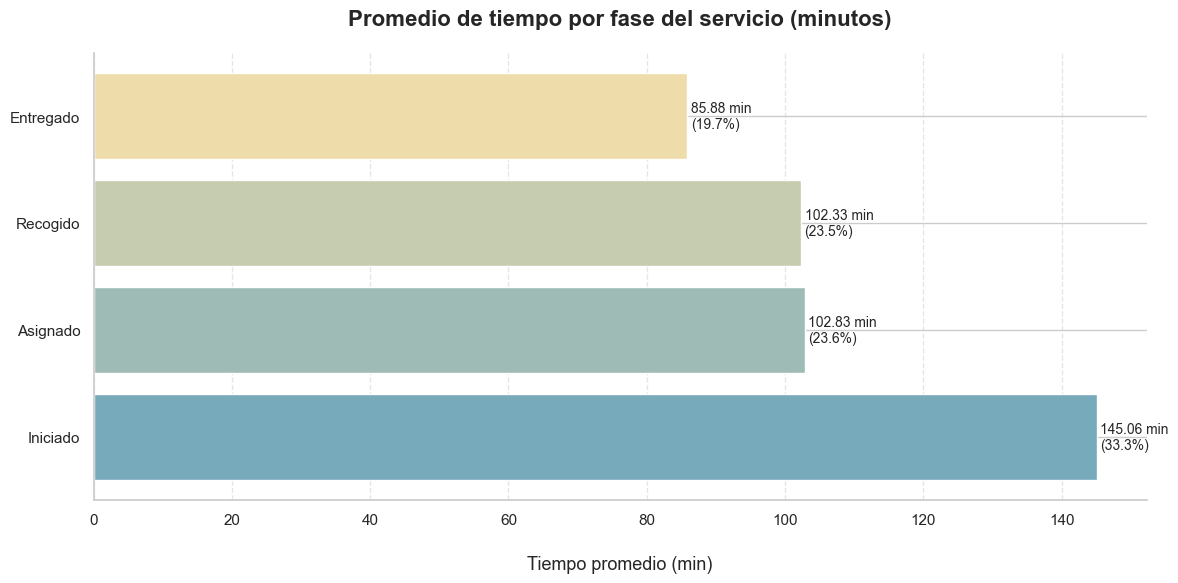

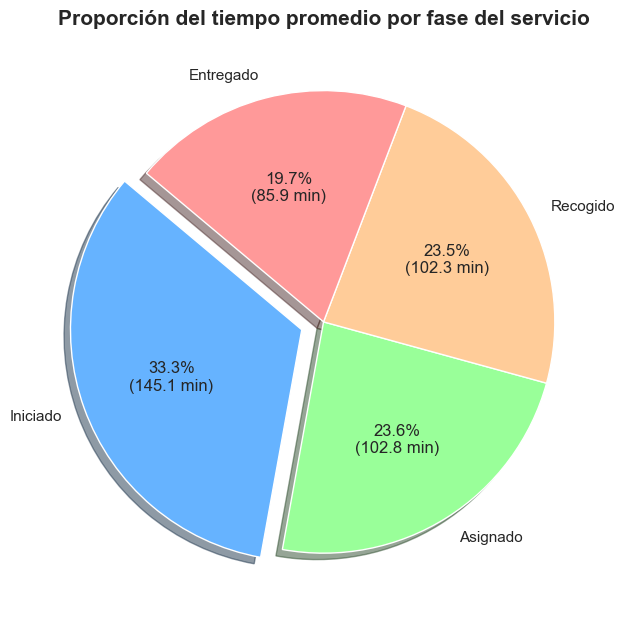


RESUMEN:

La fase más demorada en promedio es Iniciado con 145.06 minutos (33.3%) del tiempo total del servicio.



In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo visual
sns.set_theme(style="whitegrid")

# Consulta SQL
query = """
SELECT
  ROUND(AVG(tiempo_estado_iniciado)::numeric, 2) AS promedio_iniciado,
  ROUND(AVG(tiempo_estado_asignado)::numeric, 2) AS promedio_asignado,
  ROUND(AVG(tiempo_estado_recogido)::numeric, 2) AS promedio_recogido,
  ROUND(AVG(tiempo_estado_entregado)::numeric, 2) AS promedio_entregado
FROM hecho_servicio;
"""
df = pd.read_sql(query, con=engine_bodega)

# Datos
fases = ['Iniciado', 'Asignado', 'Recogido', 'Entregado']
valores = [df[col][0] for col in df.columns]

# Calcular porcentaje
total = sum(valores)
porcentajes = [(v / total * 100) for v in valores]
indice_max = valores.index(max(valores))

# Paleta de colores consistente
colores = sns.color_palette("blend:#7AB,#EDA", len(fases))

# Gráfico de barras horizontal
plt.figure(figsize=(12, 6))
bars = plt.barh(fases, valores, color=colores)


for i, (bar, pct) in enumerate(zip(bars, porcentajes)):
    width = bar.get_width()
    label = f"{width:.2f} min\n({pct:.1f}%)"
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, label,
             va='center', ha='left', fontsize=10)

plt.title("Promedio de tiempo por fase del servicio (minutos)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Tiempo promedio (min)", fontsize=13, labelpad=20)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.grid(axis='x', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()

# Gráfico de torta 
explode = [0.1 if i == indice_max else 0 for i in range(len(valores))]
colores_torta = ['#66b3ff', '#99ff99', '#ffcc99', '#ff9999']

plt.figure(figsize=(6.5, 6.5))
plt.pie(
    valores,
    labels=fases,
    autopct=lambda p: f'{p:.1f}%\n({p * total / 100:.1f} min)',
    explode=explode,
    startangle=140,
    colors=colores_torta,
    shadow=True
)
plt.title("Proporción del tiempo promedio por fase del servicio", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Resumen
fase_max = fases[indice_max]
tiempo_max = valores[indice_max]
porcentaje_max = porcentajes[indice_max]

print("\nRESUMEN:\n")
print(f"La fase más demorada en promedio es {fase_max} con {tiempo_max:.2f} minutos "
      f"({porcentaje_max:.1f}%) del tiempo total del servicio.\n")


## **Pregunta 9:** Cuáles son las novedades que más se presentan durante la prestación del servicio?

A partir de la tabla de `hechos hecho_novedades`, relacionada con la dimensión `dim_tipo_novedad`, se agruparon los registros para contar cuántas veces ocurrió cada tipo de novedad. Esto permite identificar los problemas más comunes durante la prestación del servicio, como retrasos, reclamos o incidencias

---

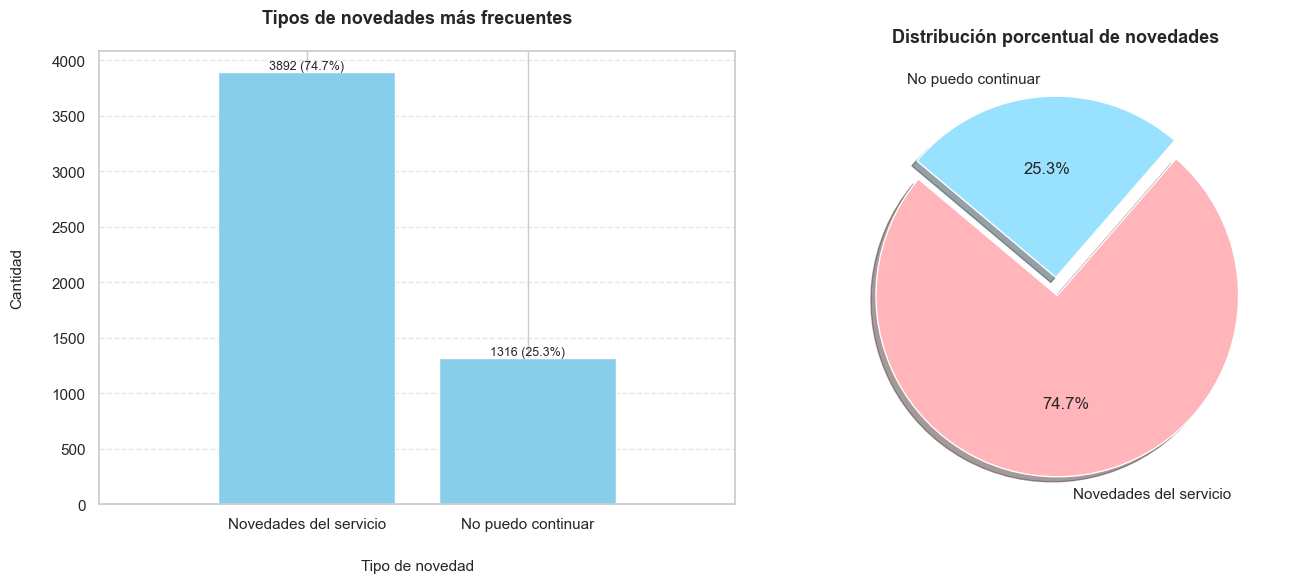

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

# Consulta SQL
query = """
SELECT 
    dtn.descripcion_novedad AS tipo_novedad,
    COUNT(*) AS cantidad
FROM hecho_novedades hn
JOIN dim_tipo_novedad dtn ON hn.id_tipo_novedad = dtn.id_tipo_novedad
GROUP BY dtn.descripcion_novedad
ORDER BY cantidad DESC;
"""
df = pd.read_sql(query, con=engine_bodega)

# Calcular total para porcentajes
total = df["cantidad"].sum()

# Colores personalizados
colors = ["#FFB5B9", "#99E2FF"]
explode = [0.1 if i == 0 else 0 for i in range(len(df))] 

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de Barras
bars = axs[0].bar(df["tipo_novedad"], df["cantidad"], color='skyblue')
axs[0].set_title("Tipos de novedades más frecuentes", fontsize=13, pad=20, fontweight='bold')
axs[0].set_xlabel("Tipo de novedad", fontsize=11, labelpad=20)
axs[0].set_ylabel("Cantidad", fontsize=11, labelpad=20)
axs[0].set_xticks(range(len(df)))
axs[0].set_xticklabels(df["tipo_novedad"], rotation=0, ha='center')
axs[0].grid(axis='y', linestyle='--', alpha=0.5)
axs[0].margins(x=0.3)

# Etiquetas sobre barras (valor + porcentaje)
for bar in bars:
    yval = bar.get_height()
    pct = (yval / total) * 100
    label = f"{int(yval)} ({pct:.1f}%)"
    axs[0].text(bar.get_x() + bar.get_width()/2, yval + 0.5, label, ha='center', va='bottom', fontsize=9)

# Gráfico de Torta 
axs[1].pie(
    df["cantidad"], 
    labels=df["tipo_novedad"], 
    autopct='%1.1f%%',
    colors=colors[:len(df)], 
    explode=explode,
    startangle=140,
    shadow=True
)
axs[1].set_title("Distribución porcentual de novedades", fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()
